In [185]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score,train_test_split
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, ParameterGrid
from sklearn.ensemble import BaggingRegressor,BaggingClassifier
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, \
accuracy_score, precision_score, confusion_matrix, mean_squared_error, r2_score
from sklearn.impute import KNNImputer
from pyearth import Earth

# Data Cleaning

In [145]:
train = pd.read_csv('train_subset.csv')

In [146]:
test = pd.read_csv('test_subset.csv')

In [147]:
y = pd.read_csv('train_labels.csv')

In [148]:
# merge response + predictors
train = pd.merge(train, y)
test = pd.merge(test, y)

In [149]:
train_filtered = train.drop(['Unnamed: 0','customer_ID','S_2','D_63','D_64'],axis=1)

In [150]:
test_filtered = test.drop(['Unnamed: 0','customer_ID','S_2','D_63','D_64'],axis=1)

In [151]:
# storing missing values for each column in train
val_train = train_filtered.isna().sum()

# storing missing values for each column in test
val_test = test_filtered.isna().sum()

In [152]:
# creating dataframe to store how many values are missing in each column for both train and test
na_df = pd.DataFrame(columns = train_filtered.columns)
test_na_df = pd.DataFrame(columns = test_filtered.columns)
test_na_df.loc['Train'] = val_train
test_na_df.loc['Test'] = val_test
na_df.loc['Train'] = val_train
na_df.loc['Test'] = val_test

In [155]:
# identify predictors with large number of missing values 
col_missing = []
for col in na_df.columns:
    if na_df.loc['Train',col]/10000 > .8:
        col_missing.append(col)

In [156]:
# identify predictors with large number of missing values 
test_col_missing = []
for col in test_na_df.columns:
    if test_na_df.loc['Train',col]/10000 > .8:
        test_col_missing.append(col)

In [157]:
# drop predictors with more than 80% missing values
train_filtered = train_filtered.drop(col_missing,axis=1)

In [160]:
test_filtered = test_filtered.drop(test_col_missing,axis=1)

In [162]:
imputer = KNNImputer(n_neighbors=1)

In [163]:
train_filtered = pd.DataFrame(imputer.fit_transform(train_filtered),columns = train_filtered.columns)

In [164]:
test_filtered = pd.DataFrame(imputer.fit_transform(test_filtered),columns = test_filtered.columns)

In [167]:
train_filtered.to_csv('train_clean.csv')

In [168]:
test_filtered.to_csv('test_clean.csv')

# Bagging

In [170]:
# Separating the predictors and response
y_train = train_filtered.target
X_train = train_filtered.drop('target',axis =1)
y_test = test_filtered.target
X_test = test_filtered.drop('target',axis=1)

In [177]:
#Bagging the results of 10 decision trees
bag_model = BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=50, random_state=1,
                        n_jobs=-1).fit(X_train, y_train)

Accuracy:  83.02000000000001
ROC-AUC:  0.9116062371417913
Precision:  0.6465914915427986
Recall:  0.8877551020408163


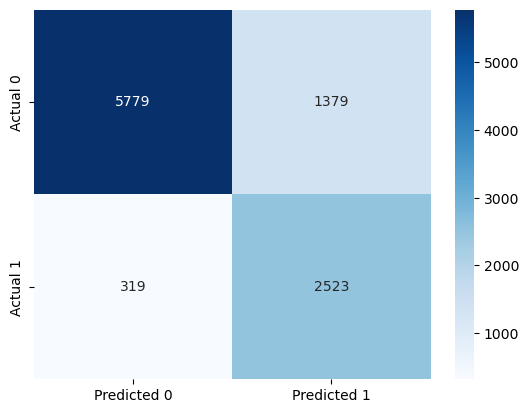

In [178]:
# Performance metrics computation for the optimum decision threshold probability
desired_threshold = 0.23

y_pred_prob = bag_model.predict_proba(X_test)[:,1] 

# Classifying observations in the positive class (y = 1) if the predicted probability is greater
# than the desired decision threshold probability
y_pred = y_pred_prob > desired_threshold
y_pred = y_pred.astype(int)

#Computing the accuracy
print("Accuracy: ",accuracy_score(y_pred, y_test)*100)  

#Computing the ROC-AUC
fpr, tpr, auc_thresholds = roc_curve(y_test, y_pred_prob)
print("ROC-AUC: ",auc(fpr, tpr))# AUC of ROC

#Computing the precision and recall
print("Precision: ", precision_score(y_test, y_pred))
print("Recall: ", recall_score(y_test, y_pred))

#Confusion matrix
cm = pd.DataFrame(confusion_matrix(y_test, y_pred), 
                  columns=['Predicted 0', 'Predicted 1'], index = ['Actual 0', 'Actual 1'])
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g');

In [190]:
params = {'max_samples': [0.5,1.0],
          'max_features': [0.5,1.0],
          'bootstrap': [True, False],
          'bootstrap_features': [True, False]}

cv = KFold(n_splits=2,shuffle=True,random_state=1)
bagging_classifier_grid = GridSearchCV(BaggingClassifier(estimator = DecisionTreeClassifier(random_state = 1),
                                                         n_estimators=250, random_state=1, n_jobs=-1),
                                       param_grid =params, cv=cv, n_jobs=-1, verbose=1,
                                       scoring = ['accuracy', 'recall'], refit='recall')
bagging_classifier_grid.fit(X_train, y_train)

print('Train accuracy : %.3f'%bagging_classifier_grid.best_estimator_.score(X_train, y_train))
print('Test accuracy : %.3f'%bagging_classifier_grid.best_estimator_.score(X_test, y_test))
print('Best accuracy Through Grid Search : %.3f'%bagging_classifier_grid.best_score_)
print('Best Parameters : ',bagging_classifier_grid.best_params_)

Fitting 2 folds for each of 16 candidates, totalling 32 fits
Train accuracy : 1.000
Test accuracy : 0.864
Best accuracy Through Grid Search : 0.922
Best Parameters :  {'bootstrap': False, 'bootstrap_features': True, 'max_features': 0.5, 'max_samples': 1.0}


In [195]:
#Bagging the results of 10 decision trees
# opt_bag_model = BaggingClassifier(estimator=DecisionTreeClassifier(random_state=1), 
#                                   n_estimators=250, 
#                                   random_state=1,
#                                   n_jobs=-1,
#                                   bootstrap = False,
#                                   booststrap_features=True,
#                                   max_features=0.5,
#                                   max_samples=1.0).fit(X_train, y_train)
opt_bag_model = BaggingClassifier(estimator=DecisionTreeClassifier(random_state=1),
                          n_estimators=250,
                          random_state=1,
                          max_features=0.5,
                          max_samples=1.0,
                          n_jobs=-1,
                          bootstrap=True,
                          bootstrap_features=False,
                                 oob_score=True).fit(X_train, y_train)